In [4]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [5]:
img = cv.imread('../Downloads/Bread plate.png',0)

In [6]:
edges = cv.Canny(img,100,200)

TypeError: Image data of dtype object cannot be converted to float

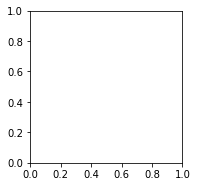

In [7]:
plt.subplot(121),plt.imshow(img,cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [1]:
import cv2
import numpy as np
import math

# input image
path = "image1.jpg"
# 1 EUR coin diameter in cm
coinDiameter = 2.325
# real area for the coin in cm^2
coinArea = (coinDiameter/2)**2 * math.pi
# initializing the multiplying factor for real size
realAreaPerPixel = 1


# pixel to cm^2
def pixelToArea(objectSizeInPixel, coinSizeInPixel):
    # how many cm^2 per pixel?
    realAreaPerPixel = coinArea / coinSizeInPixel
    print("realAreaPerPixel: ", realAreaPerPixel)
    # object area in cm^2
    objectArea = realAreaPerPixel * objectSizeInPixel
    return objectArea    


# finding coin and steak contours
def getContours(img, imgContour):
    
    # find all the contours from the B&W image
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # needed to filter only our contours of interest
    finalContours = []
    
    # for each contour found
    for cnt in contours:
        # cv2.drawContours(imgContour, cnt, -1, (255, 0, 255), 2)
        # find its area in pixel
        area = cv2.contourArea(cnt)
        print("Detected Contour with Area: ", area)

        # minimum area value is to be fixed as the one that leaves the coin as the small object on the scene
        if (area > 5000):
            perimeter = cv2.arcLength(cnt, True)
            
            # smaller epsilon -> more vertices detected [= more precision]
            epsilon = 0.002*perimeter
            # check how many vertices         
            approx = cv2.approxPolyDP(cnt, epsilon, True)
            #print(len(approx))
            
            finalContours.append([len(approx), area, approx, cnt])

    # we want only two objects here: the coin and the meat slice
    print("---\nFinal number of External Contours: ", len(finalContours))
    # so at this point finalContours should have only two elements
    # sorting in ascending order depending on the area
    finalContours = sorted(finalContours, key = lambda x:x[1], reverse=False)
    
    # drawing contours for the final objects
    for con in finalContours:
        cv2.drawContours(imgContour, con[3], -1, (0, 0, 255), 3)

    return imgContour, finalContours

    
# sourcing the input image
img = cv2.imread(path)
cv2.imshow("Starting image", img)
cv2.waitKey()

# blurring
imgBlur = cv2.GaussianBlur(img, (7, 7), 1)
# graying
imgGray = cv2.cvtColor(imgBlur, cv2.COLOR_BGR2GRAY)
# canny
imgCanny = cv2.Canny(imgGray, 255, 195)

kernel = np.ones((2, 2))
imgDil = cv2.dilate(imgCanny, kernel, iterations = 3)
# cv2.imshow("Diluted", imgDil)
imgThre = cv2.erode(imgDil, kernel, iterations = 3)

imgFinalContours, finalContours = getContours(imgThre, img)

# first final contour has the area of the coin in pixel
coinPixelArea = finalContours[0][1]
print("Coin Area in pixel", coinPixelArea)
# second final contour has the area of the meat slice in pixel
slicePixelArea = finalContours[1][1]
print("Entire Slice Area in pixel", slicePixelArea)

# let's go cm^2
print("Coin Area in cm^2:", coinArea)
print("Entire Slice Area in cm^2:", pixelToArea(slicePixelArea, coinPixelArea))

# show  the contours on the unfiltered starting image
cv2.imshow("Final External Contours", imgFinalContours)
cv2.waitKey()


# now let's detect and quantify the lean part

# convert to HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
# set lower and upper color limits
lowerVal = np.array([0, 159, 160])
upperVal = np.array([101, 255, 253])
# Threshold the HSV image to get only red colors
mask = cv2.inRange(hsv, lowerVal, upperVal)
# apply mask to original image - this shows the red with black blackground
final = cv2.bitwise_and(img, img, mask= mask)

# show selection
cv2.imshow("Lean Cut", final)
cv2.waitKey()

# convert it to grayscale because countNonZero() wants 1 channel images
gray = cv2.cvtColor(final, cv2.COLOR_BGR2GRAY)
# cv2.imshow("Gray", gray)
# cv2.waitKey()
meatyPixelArea = cv2.countNonZero(gray)

print("Red Area in pixel: ", meatyPixelArea)
print("Red Area in cm^2: ", pixelToArea(meatyPixelArea, coinPixelArea))

# finally the body-fat ratio calculation
print("Body-Fat Ratio: ", meatyPixelArea/slicePixelArea*100, "%")

cv2.destroyAllWindows()

error: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
